In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import os
from model_analysis_helpers import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import save_model, load_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
train_dataset, val_dataset, test_dataset = create_tensorflow_datasets(image_size=(520, 520),
                                                                      batch_size=32,
                                                                      shuffle = False)

Found 10520 files belonging to 196 classes.
Found 3234 files belonging to 196 classes.
Found 2431 files belonging to 196 classes.


In [4]:
car_df = pd.read_csv("./data/labeled_car_data.csv")

## Baseline Accuracy is 0.008403

In [5]:
car_df['target'].value_counts(normalize=True).sort_values(ascending=False)

119    0.008403
79     0.005993
161    0.005931
167    0.005870
56     0.005746
         ...   
175    0.003769
64     0.003645
158    0.003584
99     0.003398
136    0.002966
Name: target, Length: 196, dtype: float64

## Create a simple convolutional neural network to try to beat the baseline

In [6]:
simple_model_df = pd.read_csv("./model_histories/2021_07_20-15_45_53_conv2_E100_Oadam0005_FIRST_SIMPLE_MODEL_HISTORY.csv")
simple_model_df = add_epoch_num_column(simple_model_df)

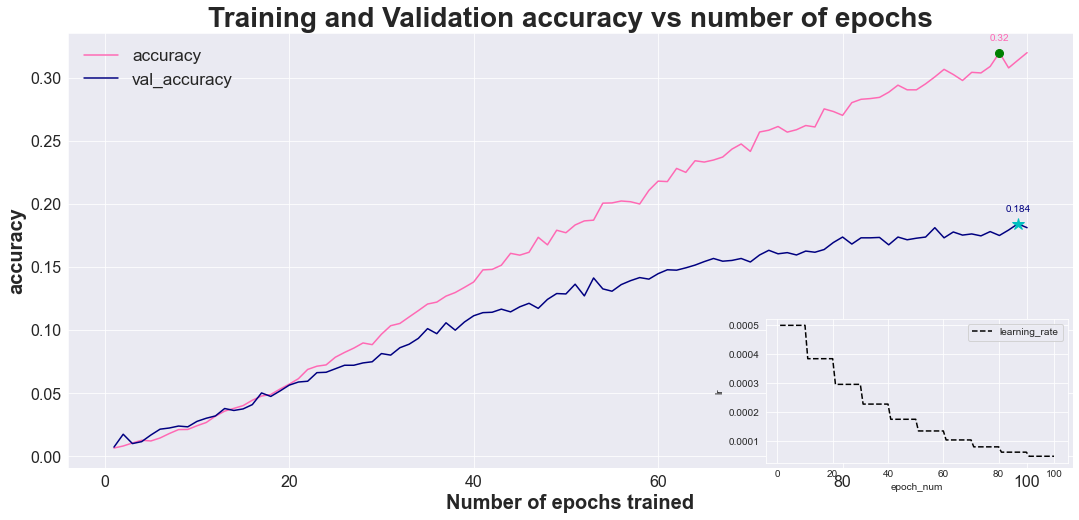

In [7]:
plot_train_val_comparison(simple_model_df, metric = 'accuracy', annotate_best_only = True, learning_rate_trace = True)

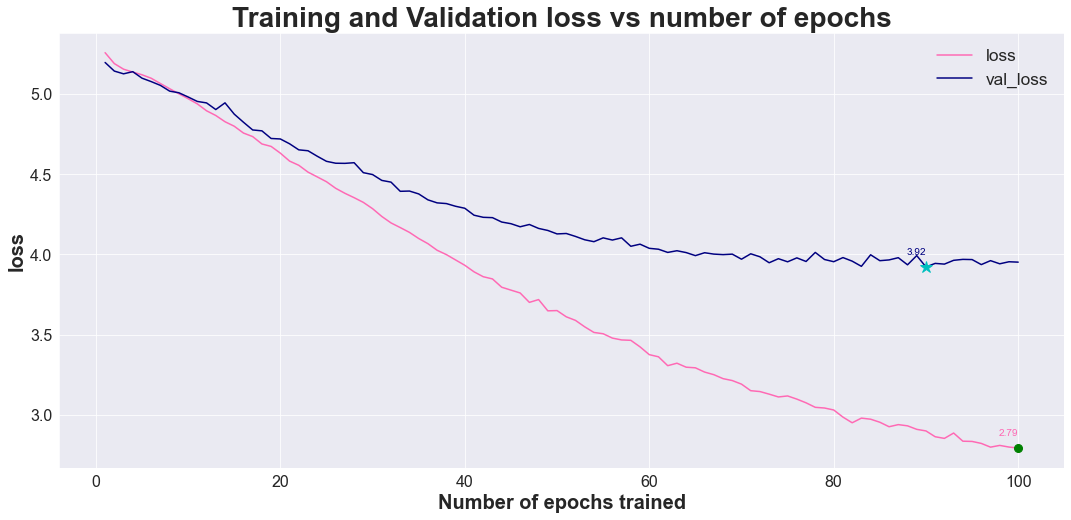

In [8]:
plot_train_val_comparison(simple_model_df, metric = 'loss', annotate_best_only = True, learning_rate_trace = False)

In [9]:
val_pred_simple_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_val_dataset_2021_07_20-15_45_53_conv2_E100_Oadam0005_B32_SIMPLE_CONVNET_MODEL_FINAL_SAVE_ALL_PREDICTIONS.csv")
test_pred_simple_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_test_dataset_2021_07_20-15_45_53_conv2_E100_Oadam0005_B32_SIMPLE_CONVNET_MODEL_FINAL_SAVE_ALL_PREDICTIONS.csv")
train_pred_simple_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_train_dataset_2021_07_20-15_45_53_conv2_E100_Oadam0005_B32_SIMPLE_CONVNET_MODEL_FINAL_SAVE_ALL_PREDICTIONS.csv")

In [10]:
print_accuracies(train_pred_simple_df, test_pred_simple_df, val_pred_simple_df)


====================================== Accuracy Report ======================================
Training: 0.5712927756653993
Training Top 5: 0.8158745247148289

Validation: 0.18119975262832405
Validation Top 5: 0.41713048855906

Test: 0.18428630193336076
Test Top 5: 0.41341011929247223



## First Resnet

#### Global average pooling at Resnet output
#### Dense layer with 256 hidden units
#### Dropout with drop probability 0.5
#### Output dense layer with 196 hidden units

In [11]:
res300_df = pd.read_csv("./model_histories/first_resnet101_history_300epochs.csv")
res300_df = add_epoch_num_column(res300_df)

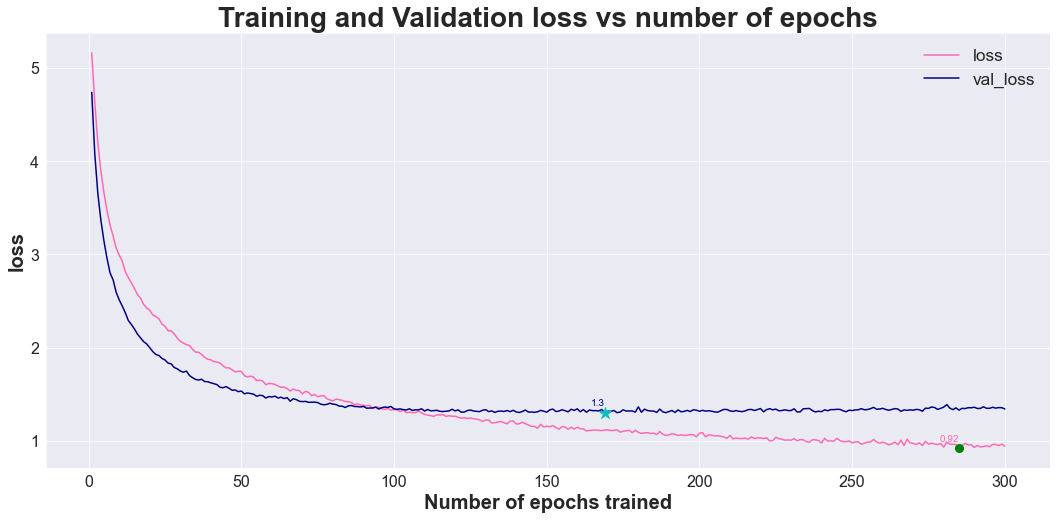

In [12]:
plot_train_val_comparison(res300_df, metric = 'loss', annotate_best_only = True)

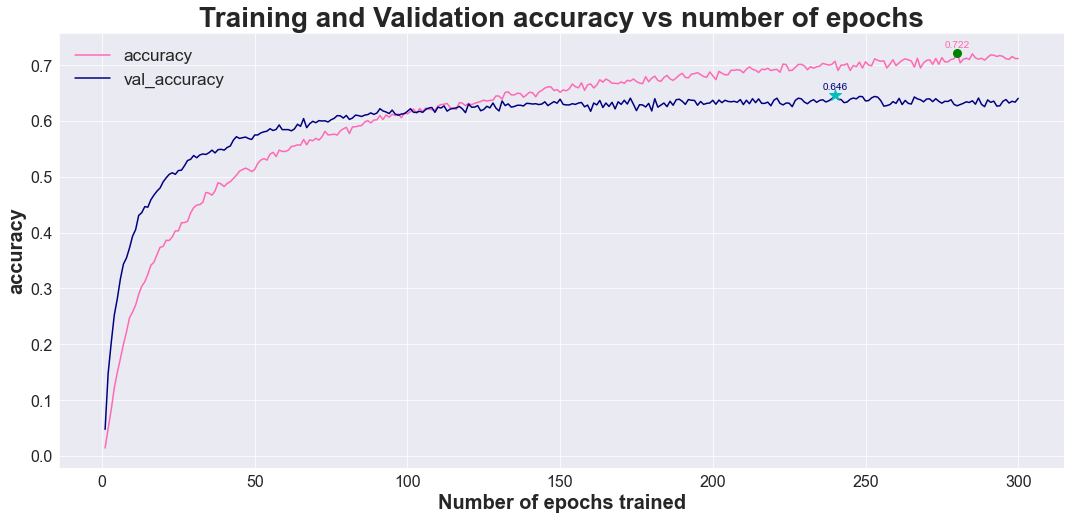

In [13]:
plot_train_val_comparison(res300_df, metric = 'accuracy', annotate_best_only = True)

## Resnet Model 2

#### Global average pooling at Resnet output
#### Dense layer with 256 hidden units
#### Dropout with drop probability 0.5
#### Output dense layer with 196 hidden units

#### Learning rate decayed every 10 epochs according to new_lr = (previous_lr / 1.3) with a minimum allowed lr of 1e-6

In [14]:
'''
initial_training_df = pd.read_csv("./model_histories/first_resnet101_lrdecay_history_300epochs.csv")
hist1_20_df = pd.read_csv("./model_histories/2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_1_TO_20_HISTORY.csv")
hist21_40_df = pd.read_csv("./model_histories/2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_21_TO_40_HISTORY.csv")
hist41_80_df = pd.read_csv("./model_histories/2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_41_TO_80_HISTORY.csv")
res_manual_lrd_df = stitch_histories(dfs = [initial_training_df, hist1_20_df, hist21_40_df, hist41_80_df]) ''';

# Reading in the file created above, for more information on what this is doing please see the detailed explaination in the next section. 
res_manual_lrd_df = pd.read_csv("./model_histories/FINAL/2021_07_20-13_14_36_manual_lrd_finetune_half_block5_ALL_HISTORY_FINAL.csv")

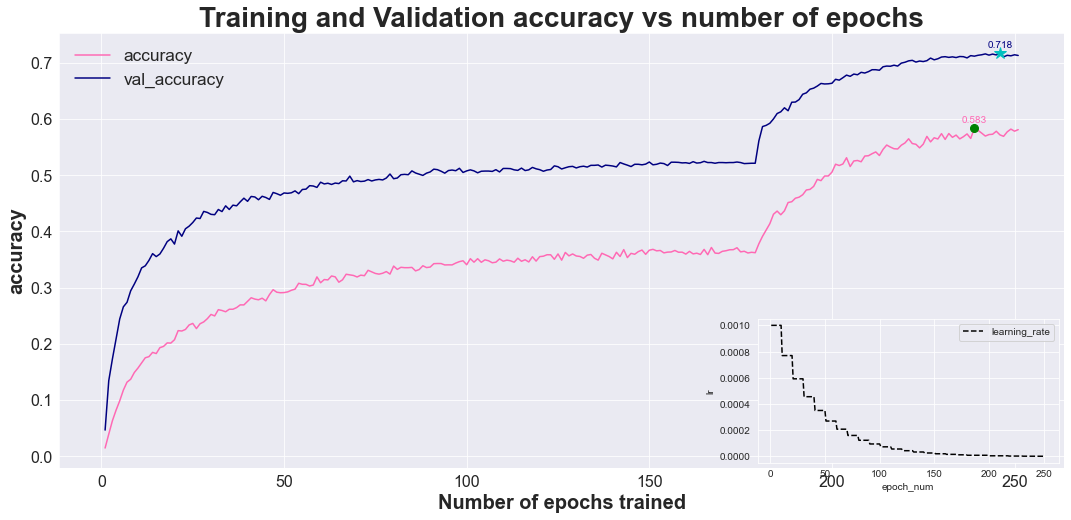

In [15]:
plot_train_val_comparison(res_manual_lrd_df, metric = 'accuracy', annotate_best_only = True, learning_rate_trace = True)

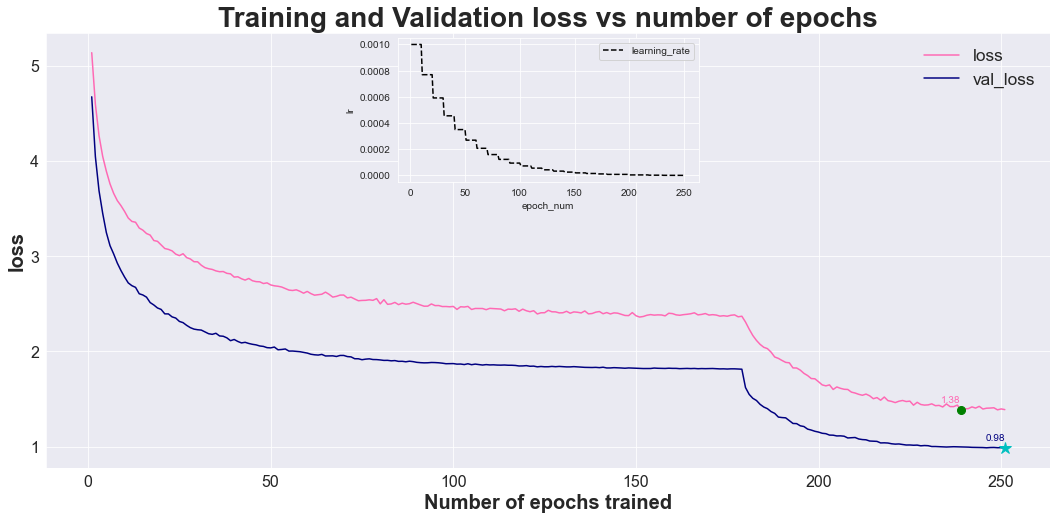

In [16]:
plot_train_val_comparison(res_manual_lrd_df, metric = 'loss', annotate_best_only = True, learning_rate_trace = True)

In [17]:
test_pred_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_test_dataset_2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_41_TO_80_FINAL_SAVE_ALL.csv")
val_pred_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_val_dataset_2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_41_TO_80_FINAL_SAVE_ALL.csv")
train_pred_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_train_dataset_2021_07_20-13_14_36_resnet101_arch1_lrdecay_FINE_TUNE_41_TO_80_FINAL_SAVE_ALL.csv")

In [18]:
print_accuracies(train_pred_df, test_pred_df, val_pred_df)


====================================== Accuracy Report ======================================
Training: 0.8912547528517111
Training Top 5: 0.9922053231939163

Validation: 0.7127396413110699
Validation Top 5: 0.9291898577612864

Test: 0.7178116001645414
Test Top 5: 0.9300699300699301



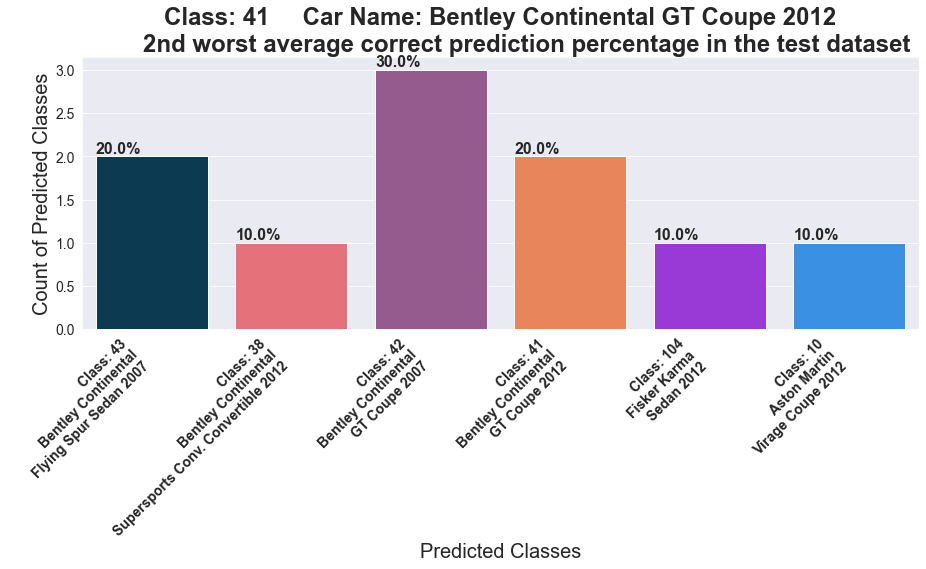

In [19]:
plot_incorrect_predictions(test_pred_df, figsize = (15, 5), offset=1)

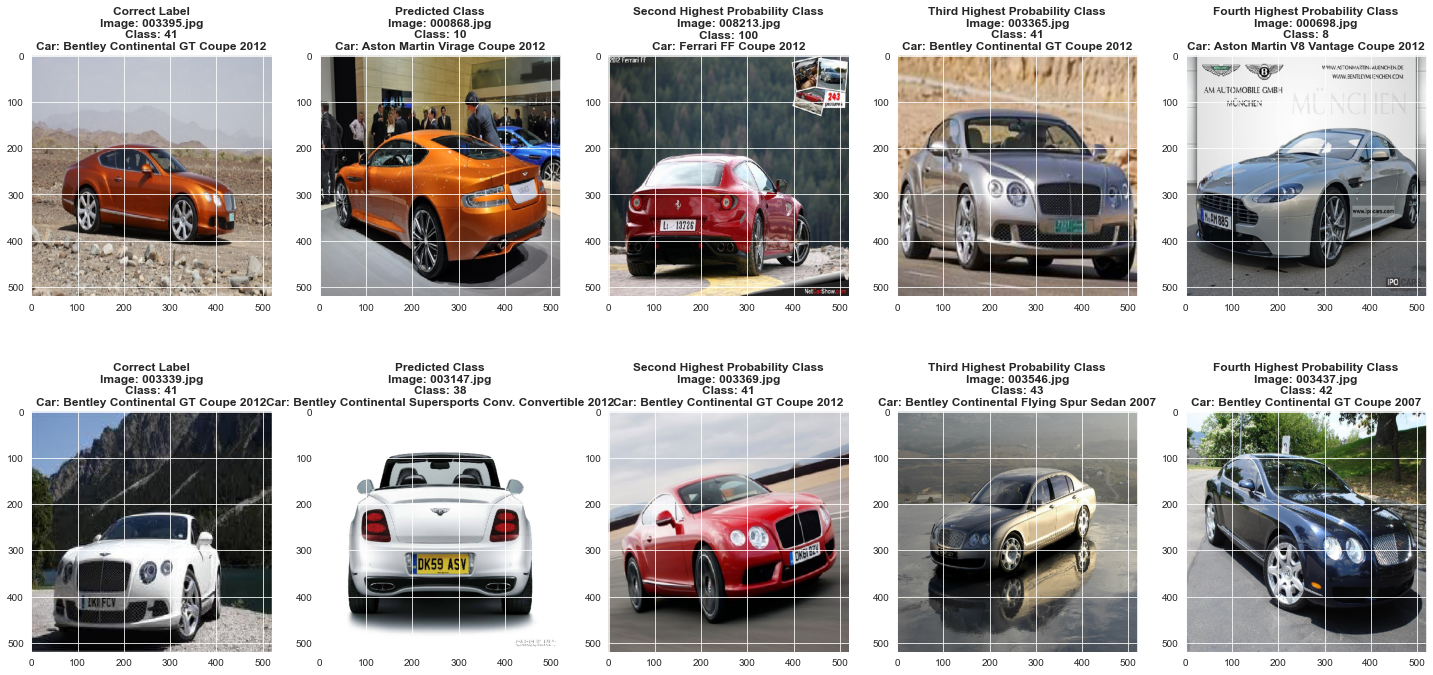

In [20]:
images_df = display_misclassified_photos(pred_df = test_pred_df, class_filter = None, direction = 'worst', rank_by ='average',
                                         num_images = 2, offset=1, n=5, dataset_type='test')

## Resnet Model 3

#### Global average pooling at Resnet output
#### Dense layer with 480 hidden units
#### Dropout with drop probability 0.5
#### Output dense layer with 196 hidden units

#### Custom learning rate schedule as shown in plot

In [21]:
res300_lrd_arch2_df = pd.read_csv("./model_histories/2021_07_23-02_04_21_resnet101_ARCH2_LRDECAY2_E300_Oadam0008_B32_HISTORY.csv")
res300_lrd_arch2_df = add_epoch_num_column(res300_lrd_arch2_df)

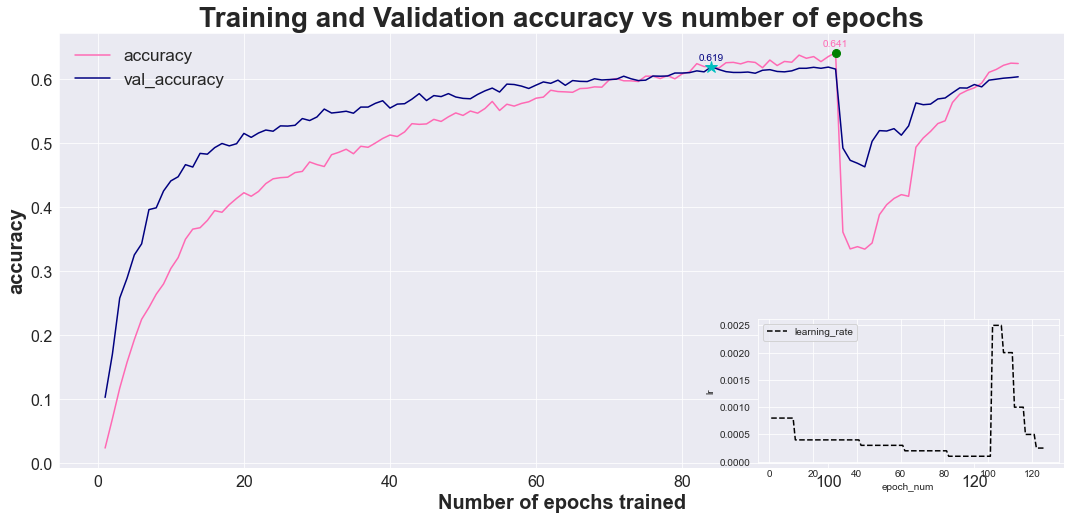

In [22]:
plot_train_val_comparison(res300_lrd_arch2_df, metric = 'accuracy', annotate_best_only = True, learning_rate_trace = True)

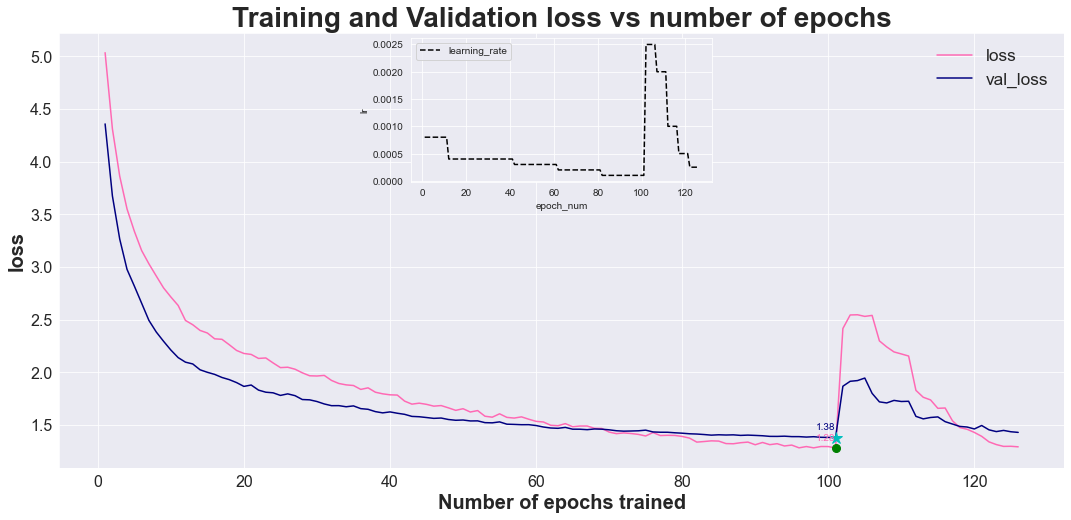

In [23]:
plot_train_val_comparison(res300_lrd_arch2_df, metric = 'loss', annotate_best_only = True, learning_rate_trace = True)

## Cyclic Learning Rate with Exponential Decay
#### exp_range learning rate
#### base learning rate = 4e-6
#### max learning rate = 4e-4
#### decay constant = 0.99994

#### Global average pooling at Resnet output
#### Dense layer with 480 hidden units
#### Dropout with drop probability 0.5
#### Output dense layer with 196 hidden units


In [24]:
res300_cyc_lrd_df = pd.read_csv("./model_histories/2021_07_23-14_24_07_resnet101_ARCH2_LR_DECAY_CYCLIC_E300_OAdam_Cyclic_Decay_4e-4_4e-6_B32_HISTORY.csv")
res300_cyc_lrd_df = add_epoch_num_column(res300_cyc_lrd_df)

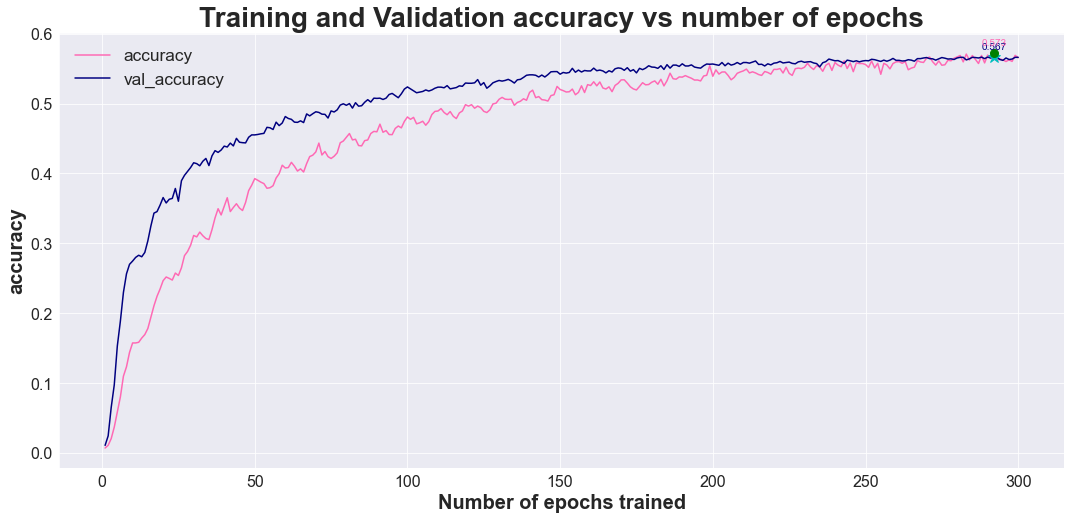

In [25]:
plot_train_val_comparison(res300_cyc_lrd_df, metric = 'accuracy', annotate_best_only = True, learning_rate_trace = False)

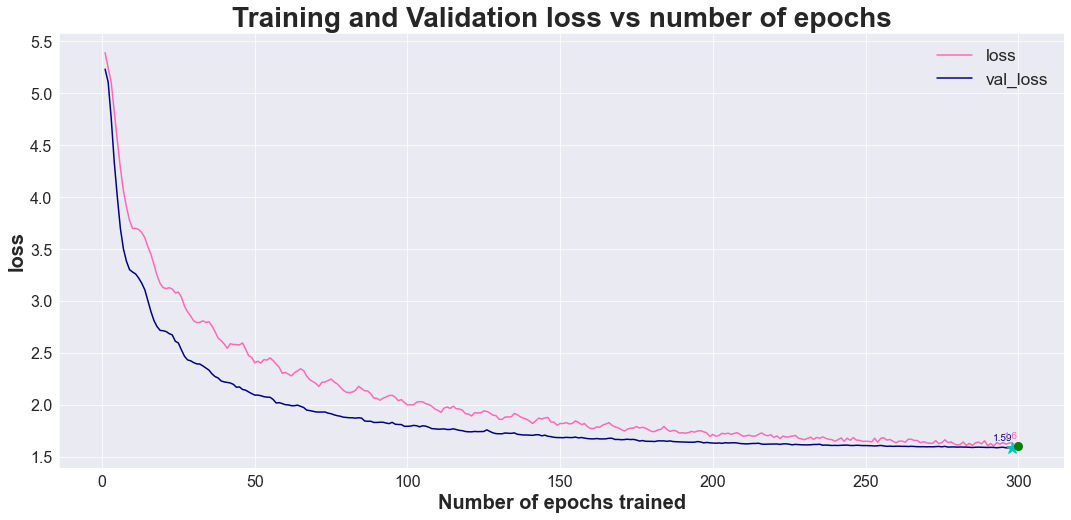

In [26]:
plot_train_val_comparison(res300_cyc_lrd_df, metric = 'loss', annotate_best_only = True, learning_rate_trace = False)

In [27]:
cyc1_pred_test_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_test_dataset_2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32_FINAL_SAVE_ALL_PREDICTIONS.csv")
cyc1_pred_train_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_train_dataset_2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32_FINAL_SAVE_ALL_PREDICTIONS.csv")
cyc1_pred_val_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_val_dataset_2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32_FINAL_SAVE_ALL_PREDICTIONS.csv")

print_accuracies(cyc1_pred_train_df, cyc1_pred_test_df, cyc1_pred_val_df)


====================================== Accuracy Report ======================================
Training: 0.8076233183856503
Training Top 5: 0.9649103139013453

Validation: 0.6126070991432069
Validation Top 5: 0.8733170134638923

Test: 0.5804195804195804
Test Top 5: 0.8449197860962567



### Cyclic Learning Rate With Exponential Decay
#### exp_range learning rate
#### base learning rate = 4e-6
#### max learning rate = 4e-4
#### decay constant = 0.99994

#### Added translation to data augmentation
#### Global average pooling at Resnet output
#### Dense layer with 480 hidden units
#### Dropout with drop probability 0.6
#### Output dense layer with 196 hidden units

In [28]:
# The code below for how to combine histories when custom callbacks and model checkpoints were used is left here as an example for anyone who would 
# like to do this in there own experiments. For my purposes, rather than continuing to rerun this code, the results of combining the dataframes has
# been saved and is simply pulled in at the end of this cell.

'''
# NOTE: The custom learning rate callback based on the 2015 paper "Cyclical Learning Rates for Training Neural Networks", Leslie N. Smith. Saves a different learning
# rate value for every BATCH of training. In order to plot one sample of the learning rate every epoch, the cyc_lr_hist_iterations_to_epochs function 
# finds the learning rate values that correspond to multiples of iterations per epoch (set as default to 329 for this project) and adds the associated learning
# rate values to the history dataframe.

# Read in the custom learning rate history
lr_df = pd.read_csv("./model_histories/2021_07_24-09_17_59_LR_DECAY_1_2e-3_6e-6_E300_OAdam_Cyclic_Decay_B32_LR_HISTORY.csv")

# Read in the standard history (generated by keras) for the same training run as the file above.
base_history_df = pd.read_csv("./model_histories/2021_07_24-09_17_59_LR_DECAY_1_2e-3_6e-6_E300_OAdam_Cyclic_Decay_B32_HISTORY.csv")

combined_df = cyc_lr_hist_iterations_to_epochs(lr_df, base_history_df)

# NOTE:
# Over the course of training and fine tuning, the same model may get trained iteratively over several different training sessions. Additionally, 
# during training a model checkpoint was always used to save the current "best model" as measured by the lowest validation loss that had occured. 
# This results in situations where the model as it existed at the end of a round of training will not be the model that gets reloaded when
# training is later resumed (i.e. the model that gets reloaded will be an earlier version when the val_loss was lower). 

# The scenario above adds a layer of complexity when trying to plot training history that spans portions of several files. The function
# "stich_histories" is helpful in these situations. Pass a list of dataframes to stitch_histories, where the list must be in the same 
# order that training actually occured (first session ---> last session). Stitch histories then returns a single dataframe that has
# combined all history dfs based on where the model checkpoint callback would have last saved.
finetune1_df = pd.read_csv("./model_histories/2021_07_24-09_17_59_FINE_TUNE1_HALF_BLOCK5_EPOCHS_1_to_15.csv")
finetune2_df = pd.read_csv("./model_histories/2021_07_24-09_17_59_FINE_TUNE1_HALF_BLOCK5_EPOCHS_15_to_50.csv")

res_cyc_lrd2_df = stitch_histories(dfs=[combined_df, finetune1_df, finetune2_df]) ''';

res_cyc_lrd2_df = pd.read_csv("./model_histories/FINAL/2021_07_24-09_17_59_cyc_lrd_finetune_half_block5_ALL_HISTORY_FINAL.csv")

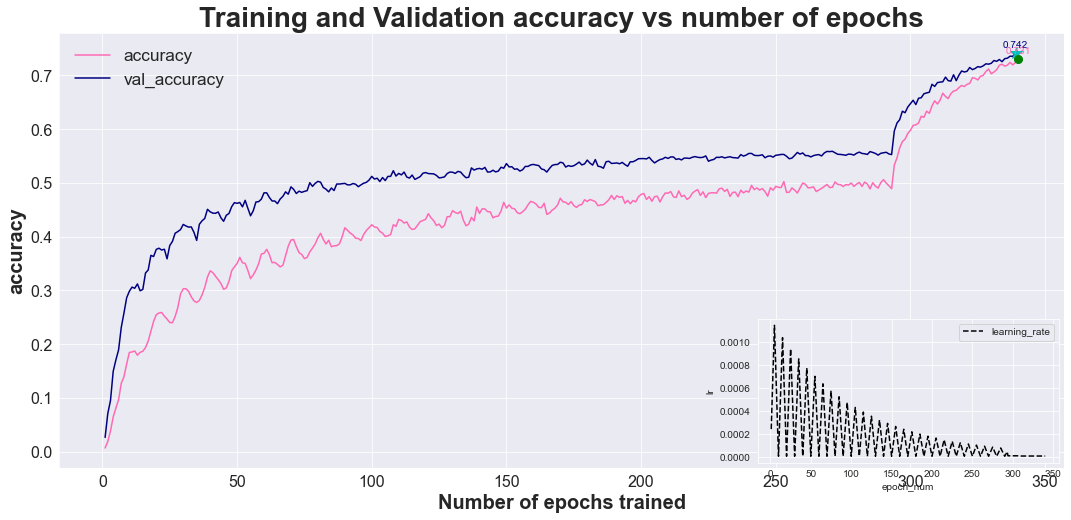

In [29]:
plot_train_val_comparison(res_cyc_lrd2_df, metric = 'accuracy', annotate_best_only = True, learning_rate_trace = True)

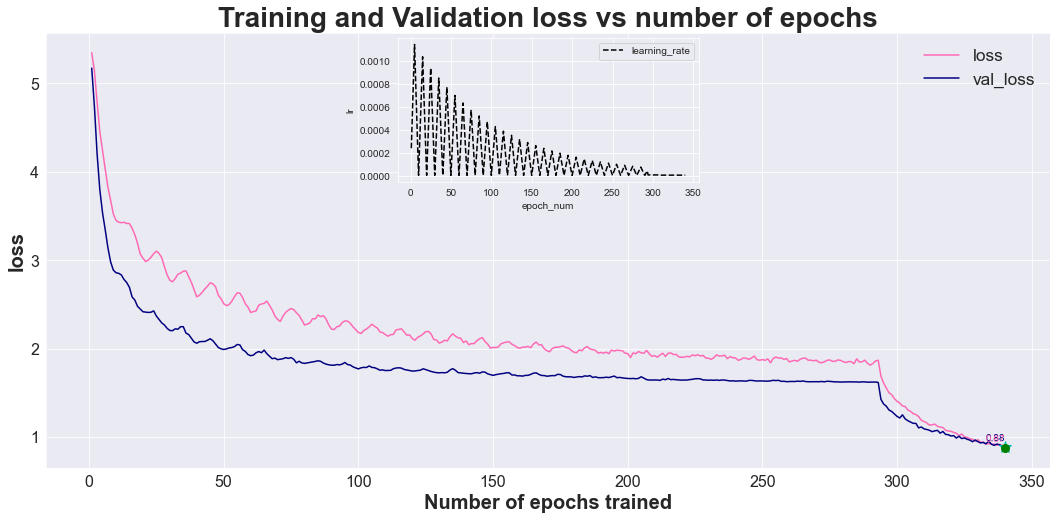

In [30]:
plot_train_val_comparison(res_cyc_lrd2_df, metric = 'loss', annotate_best_only = True, learning_rate_trace = True)

In [31]:
test_pred_res_cyc_lrd2_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_test_dataset_2021_07_24-09_17_59_FINE_TUNE_2_HALF_BLOCK5_EPOCHS_15_50_FINAL_SAVE_ALL.csv")
val_pred_res_cyc_lrd2_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_val_dataset_2021_07_24-09_17_59_FINE_TUNE_2_HALF_BLOCK5_EPOCHS_15_50_FINAL_SAVE_ALL.csv")
train_pred_res_cyc_lrd2_df = pd.read_csv("./trained_models/prediction_files/FINAL/save/top_5_predictions_WITH_FILENAMES_train_dataset_2021_07_24-09_17_59_FINE_TUNE_2_HALF_BLOCK5_EPOCHS_15_50_FINAL_SAVE_ALL.csv")

In [32]:
print_accuracies(train_pred_res_cyc_lrd2_df, test_pred_res_cyc_lrd2_df, val_pred_res_cyc_lrd2_df)


====================================== Accuracy Report ======================================
Training: 0.9360266159695817
Training Top 5: 0.9970532319391635

Validation: 0.7402597402597403
Validation Top 5: 0.948361162646877

Test: 0.7437268613739202
Test Top 5: 0.9407651172357054



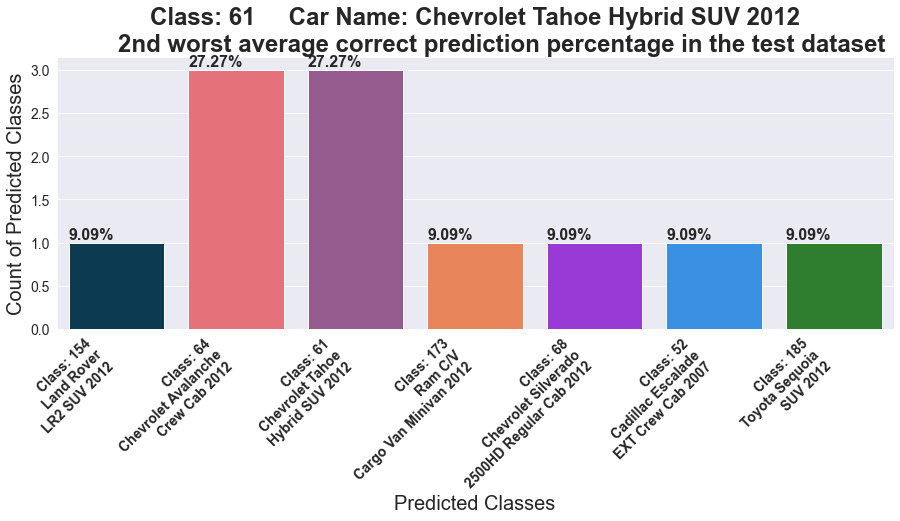

In [33]:
plot_incorrect_predictions(test_pred_res_cyc_lrd2_df, figsize = (15, 5), offset=1)

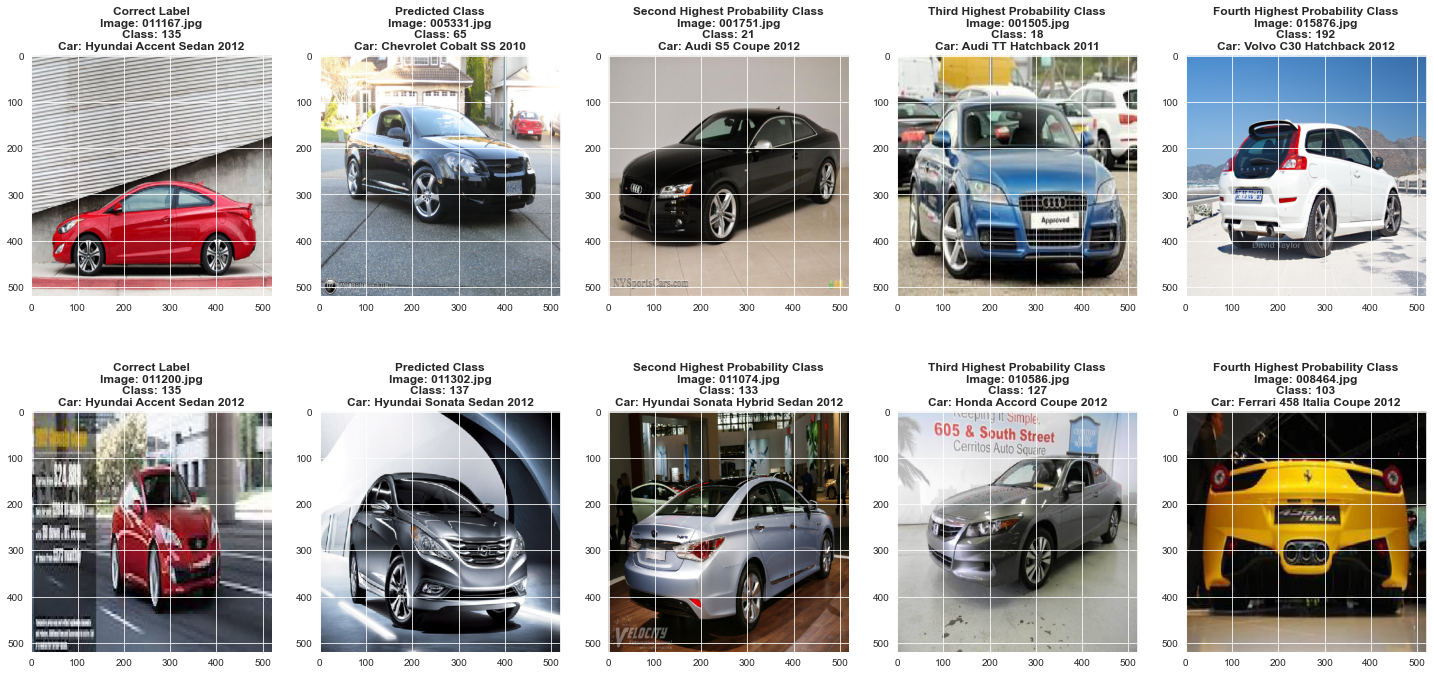

In [34]:
images_df = display_misclassified_photos(pred_df = test_pred_res_cyc_lrd2_df, class_filter = None, direction = 'worst', rank_by ='average', num_images = 2,
                                         offset=2, n=5, dataset_type='test')

## Generating Prediction Analysis Files

In [16]:
model_path = "./trained_models/convnet/2021_07_23-14_24_07_resnet101_ARCH2_LR_DECAY_CYCLIC_E300_OAdam_Cyclic_Decay_4e-4_4e-6_B32.keras"
save_path = "./trained_models/prediction_files/FINAL/"

In [17]:
pred_test_df, accuracy_results = generate_top_n_prediction_files(test_dataset,
                                                                 model_filepath = model_path,
                                                                 save_path = save_path,
                                                                 n = 5,
                                                                 model_name = "2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32",
                                                                 dataset_type='test',
                                                                 test_group_size = 10, # Number of batches that will be pulled into memory at one time, raise or lower based on available RAM.
                                                                 test_data_path = "./data/organized/test/", 
                                                                 verbose = True)


Number of examples in test dataset: 2431
Number of predictions in the dataframe: 2431


================================ Accuracy Results on test dataset for 2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32 ================================
Total number of samples: 2431

Top 5 Accuracy: 0.8449197860962567
Number of Top 5 Correct Predictions: 2054

Standard Accuracy: 0.5804195804195804
Total Correct Predictions: 1411



In [18]:
pred_train_df, accuracy_results = generate_top_n_prediction_files(train_dataset,
                                                                  model_filepath = model_path,
                                                                  save_path = save_path,
                                                                  n = 5,
                                                                  model_name = "2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32",
                                                                  dataset_type='train',
                                                                  test_group_size = 10,  # Number of batches that will be pulled into memory at one time, raise or lower based on available RAM.
                                                                  test_data_path = "./data/organized/train/", 
                                                                  car_df = car_df,
                                                                  verbose = True)


Number of examples in train dataset: 10520
Number of predictions in the dataframe: 8920


================================ Accuracy Results on train dataset for 2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32 ================================
Total number of samples: 8920

Top 5 Accuracy: 0.9649103139013453
Number of Top 5 Correct Predictions: 8607

Standard Accuracy: 0.8076233183856503
Total Correct Predictions: 7204



In [19]:
pred_val_df, accuracy_results = generate_top_n_prediction_files(val_dataset,
                                                                model_filepath = model_path,
                                                                save_path = save_path,
                                                                n = 5,
                                                                model_name = "2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32",
                                                                dataset_type='val',
                                                                test_group_size = 10,  # Number of batches that will be pulled into memory at one time, raise or lower based on available RAM.
                                                                test_data_path = "./data/organized/val/", 
                                                                car_df = car_df,
                                                                verbose = True)


Number of examples in val dataset: 3234
Number of predictions in the dataframe: 1634


================================ Accuracy Results on val dataset for 2021_07_23-14_24_07_First_Cyclic_Decay_4e-4_4e-6_B32 ================================
Total number of samples: 1634

Top 5 Accuracy: 0.8733170134638923
Number of Top 5 Correct Predictions: 1427

Standard Accuracy: 0.6126070991432069
Total Correct Predictions: 1001

